In [ ]:
from hmac import new
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import yaml
import argparse
import sys
from datetime import date
from pandas.tseries.frequencies import to_offset
from scipy.stats import beta
import os

sys.path.append('./src_torch')
from src_torch.training.models import SSMModel, SSMModelMulti
from src_torch.training.create_train_test_batch import GenerativeDataset
from src_torch.synthetic_generation.constants import *
from torch.utils.data import DataLoader

from numpy import newaxis

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:

ssm_config = {
    "bidirectional":False,
    "enc_conv" : True,
    "init_dil_conv" : True,
    "enc_conv_kernel" : 5,
    "init_conv_kernel" : 5,
    "init_conv_max_dilation" : 3,
    "global_residual":False,
    "in_proj_norm":False,
    "initial_gelu_flag":True,
    "linear_seq":15,
    "mamba2":True,
    "norm":True,
    "norm_type":"layernorm",
    "num_encoder_layers":2,
    "d_state":128,
    "residual":False,
    "token_embed_len":1024,
}

model_path = './models/mamba4cast_2l_1024_conv_i5e5.pth'
model_string = model_path.split("/")[-1].replace(".pth","")
subday = True

In [3]:
def adapt_state_dict_keys(old_state_dict):
    new_state_dict = {}

    for key in old_state_dict.keys():
        if "linear_layer" in key:
            # Extract the layer index
            layer_idx = key.split('.')[1]
            
            # Replace "linear_layer" with "stage_2_layer.0"
            new_key = key.replace(f"linear_layer", f"stage_2_layer.0")
            
            # Add the updated key to the new state dict
            new_state_dict[new_key] = old_state_dict[key]
        else:
            # Keep other keys unchanged
            new_state_dict[key] = old_state_dict[key]

    return new_state_dict

In [4]:
def generate_sine_waves(N, n_pi1=2, n_pi2=4, lin_lim=5, noise=False):
    """
    Generate a sine wave of length 2*pi with N evenly spaced points.
    
    Parameters:
    N (int): The number of points to generate.

    Returns:
    np.ndarray: The sine wave values.
    np.ndarray: The corresponding x values.
    """
    # Generate N evenly spaced points between 0 and 2*pi
    x_sin1 = np.linspace(0, 2 * n_pi1 * np.pi, N)
    x_sin2 = np.linspace(0, 2 * n_pi2 * np.pi, N)
    
    y_lin = np.linspace(0, lin_lim, N)
    # Compute the sine of these points
    y_sin1 = np.sin(x_sin1)
    y_sin2 = np.sin(x_sin2)

    y = np.stack([y_sin1, y_sin1+y_lin, y_sin1 * y_sin2, y_sin1 * y_lin], axis=0)

    if noise:
        y += np.random.normal(0, 0.05, N)
    
    return y


def scale_data(output, scaler):
    if scaler == 'custom_robust':
        output = (output['result'] * output['scale'][1].squeeze(-1)) + output['scale'][0].squeeze(-1)
    elif scaler == 'min_max':
        output = (output['result'] * (output['scale'][0].squeeze(-1) - output['scale'][1].squeeze(-1))) + output['scale'][1].squeeze(-1)
    elif scaler == 'identity':
        output = output['result']
    return output


def multipoint_predict(model, batch_x, batch_x_mark, batch_y_mark, pred_len, scaler, device):
    x = {}
    x['ts'] = batch_x_mark.to(device)
    x['history'] = batch_x.to(device)
    x['target_dates'] = batch_y_mark.to(device)
    x['task'] = torch.zeros(4,pred_len).int().to(device)
    assert isinstance(model, SSMModelMulti), "Model must be an instance of SSMModelMulti"
    output = model(x, pred_len)
    output = scale_data(output, scaler)
    output = output.detach().cpu()
    return output


In [5]:

def eval_sine_preds(model, periods, full_context_len, pred_len, noise, device):

    # Generate a sine wave
    periods = periods
    seq_len = full_context_len + pred_len
    x = generate_sine_waves(seq_len, periods[0], periods[1], noise=noise)

    # generate time stamps
    freq = freq_dict['monthly']['freq']
    start = pd.Timestamp(date.fromordinal(int((BASE_START - BASE_END)*beta.rvs(5,1)+BASE_START)))
    ts_pd =  pd.date_range(start=start, periods=seq_len, freq=to_offset(freq))

    if not subday:
        ts = np.stack([ts_pd.year.values, 
                ts_pd.month.values, 
                ts_pd.day.values, 
                ts_pd.day_of_week.values + 1, 
                ts_pd.day_of_year.values], axis=-1)
    else:
        ts = np.stack([
                ts_pd.year.values, 
                ts_pd.month.values, 
                ts_pd.day.values, 
                ts_pd.day_of_week.values + 1, 
                ts_pd.day_of_year.values,
                ts_pd.hour.values,
                ts_pd.minute.values], axis=-1)

    pred_dfs = []

    # contexts_to_eval = np.linspace(0,full_context_len-1,9).astype(int)[1:]
    contexts_to_eval = [full_context_len]

    for context_len in contexts_to_eval:
        id = [str(context_len)]
        # Create a batch
        batch = {}
        batch['ts'] = torch.tensor(ts[-(context_len+pred_len):-pred_len]).unsqueeze(0).repeat(4,1,1)
        batch['history'] = torch.tensor(x[:, -(context_len+pred_len):-pred_len])

        batch['target_dates'] = torch.tensor(ts[full_context_len:]).unsqueeze(0).repeat(4,1,1)

        output = multipoint_predict(model, batch['history'], batch['ts'], batch['target_dates'], pred_len, 'min_max', device)
        

        hist_df = pd.DataFrame({'id': id*batch['history'].shape[1],
                                'ts':ts_pd[-(context_len+pred_len):-pred_len],
                                'target_sin':x[0][-(context_len+pred_len):-pred_len],
                                'target_sinal':x[1][-(context_len+pred_len):-pred_len],
                                'target_sinms':x[2][-(context_len+pred_len):-pred_len],
                                'target_sinml':x[3][-(context_len+pred_len):-pred_len],
                                'pred_sin':x[0][-(context_len+pred_len):-pred_len],
                                'pred_sinal':x[1][-(context_len+pred_len):-pred_len],
                                'pred_sinms':x[2][-(context_len+pred_len):-pred_len],
                                'pred_sinml':x[3][-(context_len+pred_len):-pred_len]})
        pred_df = pd.DataFrame({'id': id*pred_len,
                                'ts':ts_pd[-pred_len:],
                                'target_sin':x[0][-pred_len:],
                                'target_sinal':x[1][-pred_len:],
                                'target_sinms':x[2][-pred_len:],
                                'target_sinml':x[3][-pred_len:],
                                'pred_sin':output[0],
                                'pred_sinal':output[1],
                                'pred_sinms':output[2],
                                'pred_sinml':output[3]})
        pred_dfs.append(pd.concat([hist_df,pred_df], axis=0))

    pred_df = pd.concat(pred_dfs)

    # saving the image of some predictions
    cls = contexts_to_eval # can edit this to change the context lengths to plot
    # reverse the order of the context lengths to plot
    cls = cls[::-1]
    plots = ['sin', 'sinal', 'sinms', 'sinml']
    fig, axes = plt.subplots(2, 2, figsize=(24, 8))
    plt.rcParams["figure.autolayout"] = True
    colors = ['dodgerblue']
        
    for i, plot in enumerate(plots):
        ax = axes.flatten()[i]
        sns.lineplot(data=pred_df[pred_df['id'] == str(cls[0])], x='ts', y=f'target_{plot}', ax=ax, c='lightcoral')
        ax.axvline(x = pred_df[pred_df['id'] == str(cls[0])]['ts'].values[cls[0]], color='black', linestyle='solid', linewidth=1.5)
        for j, cl in enumerate(cls):
            data = pred_df[pred_df['id'] == str(cl)].reset_index(drop=True)
            min_ts = data['ts'].min()
            sns.lineplot(data=data, x='ts', y=f'pred_{plot}', ax=ax, c=colors[j])
            ax.axvline(x=min_ts, color=colors[j], linestyle='dashed')
            ax.grid(True)
            plt.tight_layout()
        if i == 0:
            ax.set_ylabel('Function Value', fontsize=20)
            ax.set_xlabel(None)
        elif i == 1:
            ax.set_xlabel(None)
            ax.set_ylabel(None)
        elif i == 2:
            ax.set_ylabel('Function Value', fontsize=20)
            ax.set_xlabel('Time Step', fontsize=20)
        elif i == 3:
            ax.set_xlabel('Time Step', fontsize=20)
            ax.set_ylabel(None)
        ax.legend()

    plt.show()



SSMModelMulti with multipoints


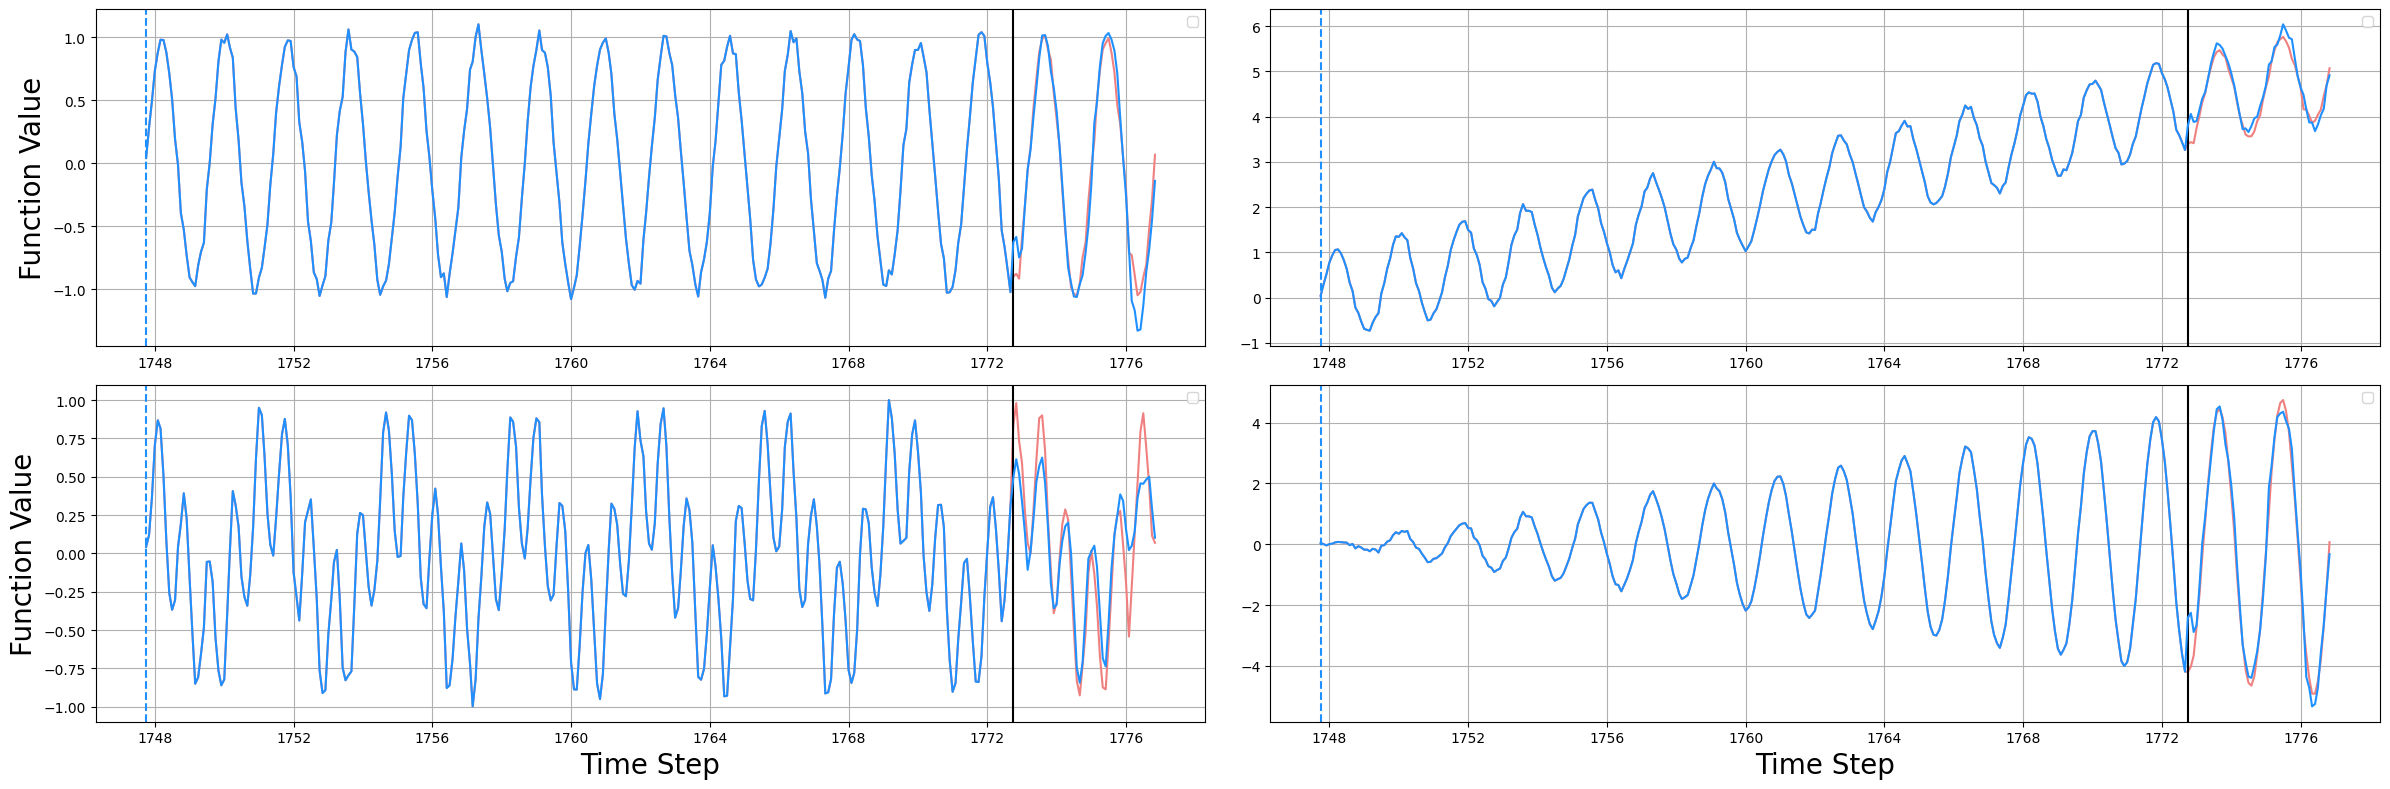

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SSMModelMulti(scaler='min_max', sub_day=subday, **ssm_config).to(device)
new_state_dict = adapt_state_dict_keys(torch.load(model_path, map_location=device)['model_state_dict'])
model.load_state_dict(new_state_dict)
model.eval()

# declare context and prediction windows:
full_context_len = 300
pred_len = 50
periods1 = 16
periods2 = 24
periods = [periods1, periods2]
exp = 'preds'

eval_sine_preds(model, periods, full_context_len, pred_len, True, device)
